In [14]:
# Warning Libraries :
import warnings
warnings.filterwarnings("ignore")

# Scientific and Data Manipulation Libraries :
import pandas as pd
import numpy as np
import math
import gc
import os
import joblib

In [15]:
class DataPreprocessor:
    def __init__(self):
        self.dataset = None
        self.X_train_scaled = None
        self.y_train = None
        self.X_test_scaled = None
        self.y_test = None
        self.test_scaled = None

    def pre_processing(self, data):
        data = data.rename(columns={'KPIs_met >80%': 'KPI_met','awards_won?':'awards_won'})
        data.drop_duplicates(keep="first", inplace=True) 
        data.set_index('employee_id', inplace=True)
        data["previous_year_rating"] = data["previous_year_rating"].fillna(0)
        data['Fresher'] = data['previous_year_rating'].apply(lambda x: 'Fresher' if x ==0 else 'Experienced')
        data["education"] = data["education"].ffill(axis = 0)
        le = LabelEncoder()
        for col in data.columns:
            if data[col].dtype == 'object':
                if len(list(data[col].unique())) <= 2:
                    le.fit(data[col])
                    data[col] = le.transform(data[col])
        self.dataset = pd.get_dummies(data)
        return self.dataset

    def scaling(self, trainset, testset):
        y = trainset['is_promoted']
        X = trainset.drop(['is_promoted'], axis=1)
        X_train, X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.001, random_state=0, stratify=y)  
        scaler = RobustScaler().fit(X_train)
        self.X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index = X_train.index)
        self.X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns,index = X_test.index)
        self.test_scaled = pd.DataFrame(scaler.transform(testset), columns=testset.columns, index = testset.index)
        return self.X_train_scaled, self.y_train, self.X_test_scaled, self.y_test, self.test_scaled


In [16]:
# ML Libraries :
from sklearn.preprocessing            import LabelEncoder, OneHotEncoder 
from sklearn.preprocessing            import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, MaxAbsScaler,LabelEncoder
from sklearn.model_selection          import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.tree                     import DecisionTreeClassifier
from sklearn.ensemble                 import VotingClassifier, RandomForestClassifier
from sklearn.metrics                  import f1_score, confusion_matrix, classification_report

# Boosting Algorithms :


# Data Visualization Libraries :
import matplotlib.pyplot as plt
# import seaborn as sns

# sklearn modules for ML model selection
from sklearn.model_selection import train_test_split  # import 'train_test_split'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

# Libraries for data modelling
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold
import joblib
import sklearn
print(sklearn.__version__)

1.2.2


In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
# conda install -c conda-forge xgboost

In [21]:
from xgboost import XGBClassifier
from catboost                         import CatBoostClassifier

In [22]:
from lightgbm                         import LGBMClassifier

In [96]:
# Define the variables you want to delete
variables_to_delete = ['X', 'y', 'X_train', 'X_test', 'y_train', 'y_test',
                       'X_train_scaled', 'X_test_scaled', 'test_scaled',
                       'trainset', 'testset']

# Loop through the variables and attempt deletion
for var_name in variables_to_delete:
    if globals().get(var_name) is not None:
        del globals()[var_name]

In [97]:
path = '/kaggle/input/analyticsvidhya-human-resource-analytics/'
# path = r'C:\\Temporary D Drive\\D Drive\\ML Projects\\Deep Learning Project\\HR-Analytics-master\\HR Analytics\\'
test = pd.read_csv(path + 'test_2umaH9m.csv')
train = pd.read_csv(path + 'train_LZdllcl.csv')

In [98]:
DP = DataPreprocessor()
trainset = DP.pre_processing(train)
testset = DP.pre_processing(test)
X_train_scaled, y_train, X_test_scaled,y_test, test_scaled = DP.scaling(trainset,testset)

In [101]:
# selection of algorithms to consider and set performance measure
models = []
models.append(("LogReg", LogisticRegression(solver="liblinear", random_state=0)))
models.append(("RF", RandomForestClassifier(n_estimators=100, random_state=0)))
# models.append(("SVM", SVC(gamma="auto", random_state=0,probability=True))) # Too much computation heavy, so I ignored this. 
models.append(("KNN", KNeighborsClassifier()))
models.append(("DT", DecisionTreeClassifier(random_state=0)))
models.append(("GNB", GaussianNB()))
models.append(("XGB", XGBClassifier(random_state=0)))
models.append(("GDB", GradientBoostingClassifier(random_state=0)))
models.append(("AdB", AdaBoostClassifier(random_state=0)))
models.append(("CB", CatBoostClassifier(random_state=0)))
models.append(("LGBM", LGBMClassifier(random_state=0)))

In [104]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

smote = SMOTE(random_state=0)

# Initialize dataframe to store predicted probabilities

all_predicted_probs = pd.DataFrame({'EID': X_train_scaled.index, "True Label": y_train})
# Initialize an empty DataFrame to store predicted probabilities for all models

# Evaluate each model using cross-validation
for name, model in models:
    print(name," Started")
#     model_params = []
    # Initialize an empty DataFrame to store predicted probabilities for the current model
    model_predicted_probs = pd.DataFrame(columns=['EID', str(name) + 'Prob'])
    i = 0
    # Perform k-fold cross-validation 
    for train_index, test_index in kfold.split(X_train_scaled, y_train):
        X_train1, X_test1 = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
        y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]
        # Apply SMOTE to the training data
        X_train1, y_train1 = smote.fit_resample(X_train1, y_train1)
        
        # Train the model
        model.fit(X_train1, y_train1)
    
        # Predict probabilities for the current fold's test set
        probabilities = model.predict_proba(X_test1)[:, 1]

        # Create a DataFrame to store the predicted probabilities for the current fold
        fold_predicted_probs = pd.DataFrame({'EID': X_test1.index, str(name) + 'Prob': probabilities})
        
        # Concatenate the fold predicted probabilities to the model's DataFrame
        model_predicted_probs = pd.concat([model_predicted_probs, fold_predicted_probs], ignore_index=True)
        
        if name in ["LogReg"]:
            
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(name, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')

 
        elif name in ['RF','KNN','GNB','AdB','CB']:
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
        
        elif name in ["DT","LGBM"]:
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
        
        elif name in ["XGB"]:
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
                        
        elif name in ["GDB"]:
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
        
        i+=1
        
    
    # Merge the predicted probabilities of the current model with the overall DataFrame
    all_predicted_probs = pd.merge(all_predicted_probs, model_predicted_probs, on='EID', how='outer')


    print(name," Done")

all_predicted_probs.head()

LogReg  Started
LogReg LogReg_B1_SMOTE_2604_fold_1
LogReg LogReg_B1_SMOTE_2604_fold_2
LogReg LogReg_B1_SMOTE_2604_fold_3
LogReg LogReg_B1_SMOTE_2604_fold_4
LogReg LogReg_B1_SMOTE_2604_fold_5
LogReg LogReg_B1_SMOTE_2604_fold_6
LogReg LogReg_B1_SMOTE_2604_fold_7
LogReg LogReg_B1_SMOTE_2604_fold_8
LogReg LogReg_B1_SMOTE_2604_fold_9
LogReg LogReg_B1_SMOTE_2604_fold_10
LogReg  Done
RF  Started
RandomForestClassifier(random_state=0) RF_B1_SMOTE_2604_fold_1
RandomForestClassifier(random_state=0) RF_B1_SMOTE_2604_fold_2
RandomForestClassifier(random_state=0) RF_B1_SMOTE_2604_fold_3
RandomForestClassifier(random_state=0) RF_B1_SMOTE_2604_fold_4
RandomForestClassifier(random_state=0) RF_B1_SMOTE_2604_fold_5
RandomForestClassifier(random_state=0) RF_B1_SMOTE_2604_fold_6
RandomForestClassifier(random_state=0) RF_B1_SMOTE_2604_fold_7
RandomForestClassifier(random_state=0) RF_B1_SMOTE_2604_fold_8
RandomForestClassifier(random_state=0) RF_B1_SMOTE_2604_fold_9
RandomForestClassifier(random_state=0) RF

,EID,True Label,LogRegProb,RFProb,KNNProb,DTProb,GNBProb,XGBProb,GDBProb,AdBProb,CBProb,LGBMProb
0,1,0,0.184276,0.01,0.0,0.0,9.999915e-01,0.025807,0.155522,0.491064,0.030302,0.045820
1,2,0,0.080281,0.00,0.0,0.0,9.981829e-01,0.002308,0.076812,0.487711,0.001790,0.001673
2,4,0,0.265316,0.05,0.8,0.0,9.997555e-01,0.004976,0.045788,0.489007,0.002544,0.003967
3,5,0,0.161829,0.02,0.0,0.0,9.999915e-01,0.025220,0.104367,0.486510,0.054605,0.044360
4,7,0,0.035270,0.00,0.0,0.0,9.046969e-23,0.002011,0.065244,0.485229,0.002171,0.003457


In [105]:
all_predicted_probs.head()
all_predicted_probs.to_csv('all_predicted_probs_SMOTE.csv')

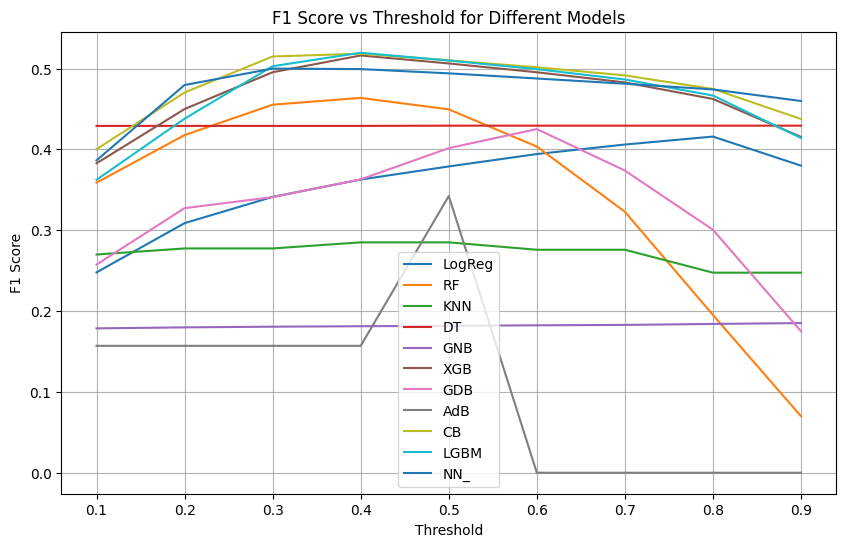

<Figure size 640x480 with 0 Axes>

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Load your data
# Assuming your data is stored in a DataFrame called 'df'
# Replace 'df' with the actual name of your DataFrame
# df = pd.read_csv("your_data.csv")

# Define the list of model names
models = ['LogReg', 'RF', 'KNN', 'DT', 
          'GNB', 'XGB', 'GDB', 'AdB', 
          'CB', 'LGBM', 'NN_']


# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.1)  # Adjust the range as needed

# Initialize a dictionary to store F1 scores for each model
f1_scores = {model: [] for model in models}

# Calculate F1 scores for each model at different threshold values
for model in models:
    for threshold in thresholds:
        # Convert model probabilities to binary predictions using threshold
        predictions = (all_predicted_probs[model + 'Prob'] > threshold).astype(int)
        # Calculate F1 score
        f1 = f1_score(all_predicted_probs['True Label_x'], predictions)
        # Append F1 score to the dictionary
        f1_scores[model].append(f1)

# Plot F1 scores for each model
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(thresholds, f1_scores[model], label=model)

# Add labels and legend
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold for Different Models')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('f1_score_vs_threshold.png')

Thrshold = 0.3

Poor Models (F1 < 0.3): Adaboost < Gaussian NB < KNN 

Average Model (0.3 < F1 < 0.5) : Decision Tree < Logistic Regression < RandomForest < Gradient Boosting
    
Best Models (F1 > 0.5) : LGBM = CatBoost > XGBoost

In [44]:
all_predicted_probs.columns

Index(['EID', 'NN_Prob', 'True Label_x', 'True Label_y', 'LogRegProb',
       'RFProb', 'KNNProb', 'DTProb', 'GNBProb', 'XGBProb', 'GDBProb',
       'AdBProb', 'CBProb', 'LGBMProb'],
      dtype='object')

In [63]:
# final_models = all_predicted_probs[['EID','True Label_x','LGBMProb','CatBoostProb','XGBoostProb','NN_Prob','Gradient BoostingProb']]

# Assuming you have a DataFrame named all_predicted_probs containing the probabilities

# Create a new DataFrame with selected columns
final_models = all_predicted_probs[['EID', 'True Label_x', 'LGBMProb', 'CBProb', 'XGBProb','NN_Prob','GDBProb']]

# Apply threshold and convert probabilities into binary predictions
threshold = 0.3
final_models['LGBMPred'] = (final_models['LGBMProb'] >= threshold).astype(int)
final_models['CatBoostPred'] = (final_models['CBProb'] >= threshold).astype(int)
final_models['XGBoostPred'] = (final_models['XGBProb'] >= threshold).astype(int)
final_models['NN_Pred'] = (final_models['NN_Prob'] >= threshold).astype(int)
final_models['GradientBoostPred'] = (final_models['GDBProb'] >= threshold).astype(int)

# Save the DataFrame
final_models.to_csv('Top5_SMOTE_models.csv', index=False)

final_models.head()

,EID,True Label_x,LGBMProb,CBProb,XGBProb,NN_Prob,GDBProb,LGBMPred,CatBoostPred,XGBoostPred,NN_Pred,GradientBoostPred
0,13122,0,0.054613,0.055610,0.217875,7.277242e-02,0.109184,0,0,0,0,0
1,30161,1,0.313984,0.520494,0.324126,1.964851e-01,0.242136,1,1,1,0,0
2,38901,0,0.000845,0.000024,0.000047,5.988634e-07,0.004543,0,0,0,0,0
3,48479,0,0.000399,0.000005,0.000019,1.145751e-09,0.003064,0,0,0,0,0
4,30442,1,0.112521,0.092546,0.081851,1.705215e-01,0.114353,0,0,0,0,0


In [64]:
# Assuming you have true labels and predicted probabilities for each model
# true_labels, pred_probs_lgbm, pred_probs_catboost, pred_probs_xgboost

# Define a threshold
# threshold = 0.4

# Convert probabilities to binary predictions based on the threshold
true_labels = final_models['True Label_x']

pred_labels_lgbm = final_models['LGBMPred']
pred_labels_catboost = final_models['CatBoostPred']
pred_labels_xgboost = final_models['XGBoostPred']
pred_labels_nn = final_models['NN_Pred']
pred_labels_gdb = final_models['GradientBoostPred']

prob_lgbm = final_models['LGBMProb']
prob_catboost = final_models['CBProb']
prob_xgboost = final_models['XGBProb']
prob_nn = final_models['NN_Prob']
prob_gdb = final_models['GDBProb']


In [65]:
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, f1_score

# Assuming you have true labels and predicted labels for each model
# true_labels, pred_labels_lgbm, pred_labels_catboost, pred_labels_xgboost
# prob_lgbm, prob_catboost, prob_xgboost
# sample_weight

# Accuracy
accuracy_lgbm = (true_labels == pred_labels_lgbm).mean()
accuracy_catboost = (true_labels == pred_labels_catboost).mean()
accuracy_xgboost = (true_labels == pred_labels_xgboost).mean()

accuracy_nn = (true_labels == pred_labels_nn).mean()
accuracy_gdb = (true_labels == pred_labels_gdb).mean()


In [66]:
# Balanced Accuracy
def balanced_accuracy(true_labels, pred_labels):
    tp = sum((true_labels == 1) & (pred_labels == 1))
    tn = sum((true_labels == 0) & (pred_labels == 0))
    fp = sum((true_labels == 0) & (pred_labels == 1))
    fn = sum((true_labels == 1) & (pred_labels == 0))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    balanced_acc = (sensitivity + specificity) / 2
    return balanced_acc

balanced_accuracy_lgbm = balanced_accuracy(true_labels, pred_labels_lgbm)
balanced_accuracy_catboost = balanced_accuracy(true_labels, pred_labels_catboost)
balanced_accuracy_xgboost = balanced_accuracy(true_labels, pred_labels_xgboost)

balanced_accuracy_nn = balanced_accuracy(true_labels, pred_labels_nn)
balanced_accuracy_gdb = balanced_accuracy(true_labels, pred_labels_gdb)

In [67]:
from sklearn.metrics import roc_auc_score

roc_auc_lgbm = roc_auc_score(true_labels, prob_lgbm)
roc_auc_catboost = roc_auc_score(true_labels, prob_catboost)
roc_auc_xgboost = roc_auc_score(true_labels, prob_xgboost)

roc_auc_nn = roc_auc_score(true_labels, prob_nn)
roc_auc_gdb = roc_auc_score(true_labels, prob_gdb)

In [68]:
# Average Precision
def average_precision(true_labels, probabilities):
    sorted_indices = np.argsort(probabilities)[::-1]
    true_labels_sorted = true_labels[sorted_indices]
    n_pos = sum(true_labels)
    n_neg = len(true_labels) - n_pos
    precisions = []
    tp = 0
    fp = 0
    for i in range(len(sorted_indices)):
        if true_labels_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        precision = tp / (tp + fp)
        if true_labels_sorted[i] == 1:
            precisions.append(precision)
    return np.mean(precisions)

average_precision_lgbm = average_precision(true_labels, prob_lgbm)
average_precision_catboost = average_precision(true_labels, prob_catboost)
average_precision_xgboost = average_precision(true_labels, prob_xgboost)

average_precision_nn = average_precision(true_labels, prob_nn)
average_precision_gdb = average_precision(true_labels, prob_gdb)

In [69]:
# Precision, Recall, F1 Score
def precision_recall_f1(true_labels, pred_labels):
    tp = sum((true_labels == 1) & (pred_labels == 1))
    tn = sum((true_labels == 0) & (pred_labels == 0))
    fp = sum((true_labels == 0) & (pred_labels == 1))
    fn = sum((true_labels == 1) & (pred_labels == 0))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

precision_lgbm, recall_lgbm, f1_lgbm = precision_recall_f1(true_labels, pred_labels_lgbm)
precision_catboost, recall_catboost, f1_catboost = precision_recall_f1(true_labels, pred_labels_catboost)
precision_xgboost, recall_xgboost, f1_xgboost = precision_recall_f1(true_labels, pred_labels_xgboost)

precision_nn, recall_nn, f1_nn = precision_recall_f1(true_labels, pred_labels_nn)
precision_gdb, recall_gdb, f1_gdb = precision_recall_f1(true_labels, pred_labels_gdb)


In [70]:
# Precision Macro
def precision_macro(true_labels, pred_labels):
    num_classes = len(np.unique(true_labels))
    precisions = []
    for class_label in range(num_classes):
        tp = sum((true_labels == class_label) & (pred_labels == class_label))
        fp = sum((true_labels != class_label) & (pred_labels == class_label))
        if tp + fp == 0:
            precision = 0  # Handle division by zero
        else:
            precision = tp / (tp + fp)
        precisions.append(precision)
    return np.mean(precisions)

precision_macro_lgbm = precision_macro(true_labels, pred_labels_lgbm)
precision_macro_catboost = precision_macro(true_labels, pred_labels_catboost)
precision_macro_xgboost = precision_macro(true_labels, pred_labels_xgboost)

precision_macro_nn = precision_macro(true_labels, pred_labels_nn)
precision_macro_gdb = precision_macro(true_labels, pred_labels_gdb)


In [71]:
# Precision Micro
def precision_micro(true_labels, pred_labels):
    tp_total = sum((true_labels == pred_labels) & (true_labels == 1))
    fp_total = sum((true_labels != pred_labels) & (true_labels == 0))
    if tp_total + fp_total == 0:
        precision_micro = 0  # Handle division by zero
    else:
        precision_micro = tp_total / (tp_total + fp_total)
    return precision_micro

precision_micro_lgbm = precision_micro(true_labels, pred_labels_lgbm)
precision_micro_catboost = precision_micro(true_labels, pred_labels_catboost)
precision_micro_xgboost = precision_micro(true_labels, pred_labels_xgboost)

precision_micro_nn = precision_micro(true_labels, pred_labels_nn)
precision_micro_gdb = precision_micro(true_labels, pred_labels_gdb)


In [72]:
def precision_samples(true_labels, pred_labels):
    tp = ((true_labels == 1) & (pred_labels == 1)).sum()
    fp = ((true_labels == 0) & (pred_labels == 1)).sum()
    if tp + fp == 0:
        return 0  # Handle division by zero
    else:
        return tp / (tp + fp)

precision_samples_lgbm = precision_samples(true_labels, pred_labels_lgbm)
precision_samples_catboost = precision_samples(true_labels, pred_labels_catboost)
precision_samples_xgboost = precision_samples(true_labels, pred_labels_xgboost)

precision_samples_nn = precision_samples(true_labels, pred_labels_nn)
precision_samples_gdb = precision_samples(true_labels, pred_labels_gdb)



In [73]:
# Precision Weighted
def precision_weighted(true_labels, pred_labels, sample_weight):
    num_classes = len(np.unique(true_labels))
    precisions = []
    for class_label in range(num_classes):
        tp = sum((true_labels == class_label) & (pred_labels == class_label))
        fp = sum((true_labels != class_label) & (pred_labels == class_label))
        if tp + fp == 0:
            precision = 0  # Handle division by zero
        else:
            precision = tp / (tp + fp)
        precisions.append(precision * sample_weight[class_label])
    return np.sum(precisions) / np.sum(sample_weight)
sample_weight = np.array([0.5,0.5])
precision_weighted_lgbm = precision_weighted(true_labels, pred_labels_lgbm, sample_weight)
precision_weighted_catboost = precision_weighted(true_labels, pred_labels_catboost, sample_weight)
precision_weighted_xgboost = precision_weighted(true_labels, pred_labels_xgboost, sample_weight)

precision_weighted_nn = precision_weighted(true_labels, pred_labels_nn, sample_weight)
precision_weighted_gdb = precision_weighted(true_labels, pred_labels_gdb, sample_weight)


In [74]:
# Recall Macro
def recall_macro(true_labels, pred_labels):
    num_classes = len(np.unique(true_labels))
    recalls = []
    for class_label in range(num_classes):
        tp = sum((true_labels == class_label) & (pred_labels == class_label))
        fn = sum((true_labels == class_label) & (pred_labels != class_label))
        if tp + fn == 0:
            recall = 0  # Handle division by zero
        else:
            recall = tp / (tp + fn)
        recalls.append(recall)
    return np.mean(recalls)

recall_macro_lgbm = recall_macro(true_labels, pred_labels_lgbm)
recall_macro_catboost = recall_macro(true_labels, pred_labels_catboost)
recall_macro_xgboost = recall_macro(true_labels, pred_labels_xgboost)

recall_macro_nn = recall_macro(true_labels, pred_labels_nn)
recall_macro_gdb = recall_macro(true_labels, pred_labels_gdb)

In [75]:
def recall_samples(true_labels, pred_labels):
    num_samples = len(true_labels)
    recalls = []
    for i in range(num_samples):
        if true_labels[i] == 1:
            tp = int(true_labels[i] == pred_labels[i])
            fn = int(true_labels[i] != pred_labels[i])
            recall = tp / (tp + fn) if (tp + fn) != 0 else 0
            recalls.append(recall)
    return np.mean(recalls)

# Call the function for each model
recall_samples_lgbm = recall_samples(true_labels, pred_labels_lgbm)
recall_samples_catboost = recall_samples(true_labels, pred_labels_catboost)
recall_samples_xgboost = recall_samples(true_labels, pred_labels_xgboost)

recall_samples_nn = recall_samples(true_labels, pred_labels_nn)
recall_samples_gdb = recall_samples(true_labels, pred_labels_gdb)


In [76]:
#  Recall Micro
recall_micro_lgbm = recall_score(true_labels, pred_labels_lgbm, average='micro')
recall_micro_catboost = recall_score(true_labels, pred_labels_catboost, average='micro')
recall_micro_xgboost = recall_score(true_labels, pred_labels_xgboost, average='micro')

recall_micro_nn = recall_score(true_labels, pred_labels_nn, average='micro')
recall_micro_gdb = recall_score(true_labels, pred_labels_gdb, average='micro')


# Recall Weighted
recall_weighted_lgbm = recall_score(true_labels, pred_labels_lgbm, average='weighted')
recall_weighted_catboost = recall_score(true_labels, pred_labels_catboost, average='weighted')
recall_weighted_xgboost = recall_score(true_labels, pred_labels_xgboost, average='weighted')

recall_weighted_nn = recall_score(true_labels, pred_labels_nn, average='weighted')
recall_weighted_gdb = recall_score(true_labels, pred_labels_gdb, average='weighted')


In [77]:
# F1 Score Macro
f1_macro_lgbm = f1_score(true_labels, pred_labels_lgbm, average='macro')
f1_macro_catboost = f1_score(true_labels, pred_labels_catboost, average='macro')
f1_macro_xgboost = f1_score(true_labels, pred_labels_xgboost, average='macro')

f1_macro_nn = f1_score(true_labels, pred_labels_nn, average='macro')
f1_macro_gdb = f1_score(true_labels, pred_labels_gdb, average='macro')

In [78]:
# F1 Score Micro
f1_micro_lgbm = f1_score(true_labels, pred_labels_lgbm, average='micro')
f1_micro_catboost = f1_score(true_labels, pred_labels_catboost, average='micro')
f1_micro_xgboost = f1_score(true_labels, pred_labels_xgboost, average='micro')

f1_micro_nn = f1_score(true_labels, pred_labels_nn, average='micro')
f1_micro_gdb = f1_score(true_labels, pred_labels_gdb, average='micro')


In [79]:
# F1 Score Weighted
f1_weighted_lgbm = f1_score(true_labels, pred_labels_lgbm, average='weighted')
f1_weighted_catboost = f1_score(true_labels, pred_labels_catboost, average='weighted')
f1_weighted_xgboost = f1_score(true_labels, pred_labels_xgboost, average='weighted')

f1_weighted_nn = f1_score(true_labels, pred_labels_nn, average='weighted')
f1_weighted_gdb = f1_score(true_labels, pred_labels_gdb, average='weighted')


In [80]:
import pandas as pd

# Create a dictionary to store the metrics
metrics_data = {
    "Model": ["LightGBM", "CatBoost", "XGBoost", "NN", "Gradient_Boost"],
    "Accuracy": [accuracy_lgbm, accuracy_catboost, accuracy_xgboost, accuracy_nn, accuracy_gdb],
    "Balanced Accuracy": [balanced_accuracy_lgbm, balanced_accuracy_catboost, balanced_accuracy_xgboost, balanced_accuracy_nn, balanced_accuracy_gdb],
    "ROC AUC": [roc_auc_lgbm, roc_auc_catboost, roc_auc_xgboost, roc_auc_nn, roc_auc_gdb],
    "Average Precision": [average_precision_lgbm, average_precision_catboost, average_precision_xgboost, average_precision_nn, average_precision_gdb],
    "Precision": [precision_lgbm, precision_catboost, precision_xgboost, precision_nn, precision_gdb],
    "Recall": [recall_lgbm, recall_catboost, recall_xgboost, recall_nn, recall_gdb],
    "F1 Score": [f1_lgbm, f1_catboost, f1_xgboost, f1_nn, f1_gdb],
    "Precision Macro": [precision_macro_lgbm, precision_macro_catboost, precision_macro_xgboost, precision_macro_nn, precision_macro_gdb],
    "Precision Micro": [precision_micro_lgbm, precision_micro_catboost, precision_micro_xgboost, precision_micro_nn, precision_micro_gdb],
    "Precision Samples": [precision_samples_lgbm, precision_samples_catboost, precision_samples_xgboost, precision_samples_nn, precision_samples_gdb],
    "Precision Weighted": [precision_weighted_lgbm, precision_weighted_catboost, precision_weighted_xgboost, precision_weighted_nn, precision_weighted_gdb],
    "Recall Macro": [recall_macro_lgbm, recall_macro_catboost, recall_macro_xgboost, recall_macro_nn, recall_macro_gdb],
    "Recall Micro": [recall_micro_lgbm, recall_micro_catboost, recall_micro_xgboost, recall_micro_nn, recall_micro_gdb],
    "Recall Samples": [recall_samples_lgbm, recall_samples_catboost, recall_samples_xgboost, recall_samples_nn, recall_samples_gdb],
    "Recall Weighted": [recall_weighted_lgbm, recall_weighted_catboost, recall_weighted_xgboost, recall_weighted_nn, recall_weighted_gdb],
    "F1 Score Macro": [f1_macro_lgbm, f1_macro_catboost, f1_macro_xgboost, f1_macro_nn, f1_macro_gdb],
    "F1 Score Micro": [f1_micro_lgbm, f1_micro_catboost, f1_micro_xgboost, f1_micro_nn, f1_micro_gdb],
    "F1 Score Weighted": [f1_weighted_lgbm, f1_weighted_catboost, f1_weighted_xgboost, f1_weighted_nn, f1_weighted_gdb]
}


# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
display(metrics_df)


,Model,Accuracy,Balanced Accuracy,ROC AUC,Average Precision,Precision,Recall,F1 Score,Precision Macro,Precision Micro,Precision Samples,Precision Weighted,Recall Macro,Recall Micro,Recall Samples,Recall Weighted,F1 Score Macro,F1 Score Micro,F1 Score Weighted
0,LightGBM,0.938360,0.692177,0.910876,0.086077,0.768333,0.395454,0.522158,0.857244,0.768333,0.768333,0.857244,0.692177,0.938360,0.395454,0.938360,0.744606,0.938360,0.929166
1,CatBoost,0.934378,0.701281,0.910846,0.086077,0.687719,0.420330,0.521762,0.817821,0.687719,0.687719,0.817821,0.701281,0.934378,0.420330,0.934378,0.743267,0.934378,0.927043
2,XGBoost,0.929776,0.701683,0.907344,0.086077,0.629349,0.426764,0.508626,0.788769,0.629349,0.629349,0.788769,0.701683,0.929776,0.426764,0.929776,0.735406,0.929776,0.923559
3,NN,0.940679,0.672926,0.903072,0.086077,0.882226,0.350204,0.501382,0.912475,0.882226,0.882226,0.912475,0.672926,0.940679,0.350204,0.940679,0.734923,0.940679,0.928685
4,Gradient_Boost,0.939839,0.673925,0.903225,0.086077,0.855215,0.353421,0.500152,0.899071,0.855215,0.855215,0.899071,0.673925,0.939839,0.353421,0.939839,0.734073,0.939839,0.928150


In [81]:
metrics_df.to_csv('Top5_SMOTE_Models_All_Metrics.csv', index= False)

In [82]:
metrics = metrics_df.columns[1:]
lightgbm_values = metrics_df.iloc[0][1:].tolist()
catboost_values = metrics_df.iloc[1][1:].tolist()
xgboost_values = metrics_df.iloc[2][1:].tolist()
nn_values = metrics_df.iloc[3][1:].tolist()
gdb_values = metrics_df.iloc[4][1:].tolist()

In [83]:
# Convert the lists to Series for easier calculation
lightgbm_series = pd.Series(lightgbm_values)
catboost_series = pd.Series(catboost_values)
xgboost_series = pd.Series(xgboost_values)
nn_series = pd.Series(nn_values)
gdb_series = pd.Series(gdb_values)

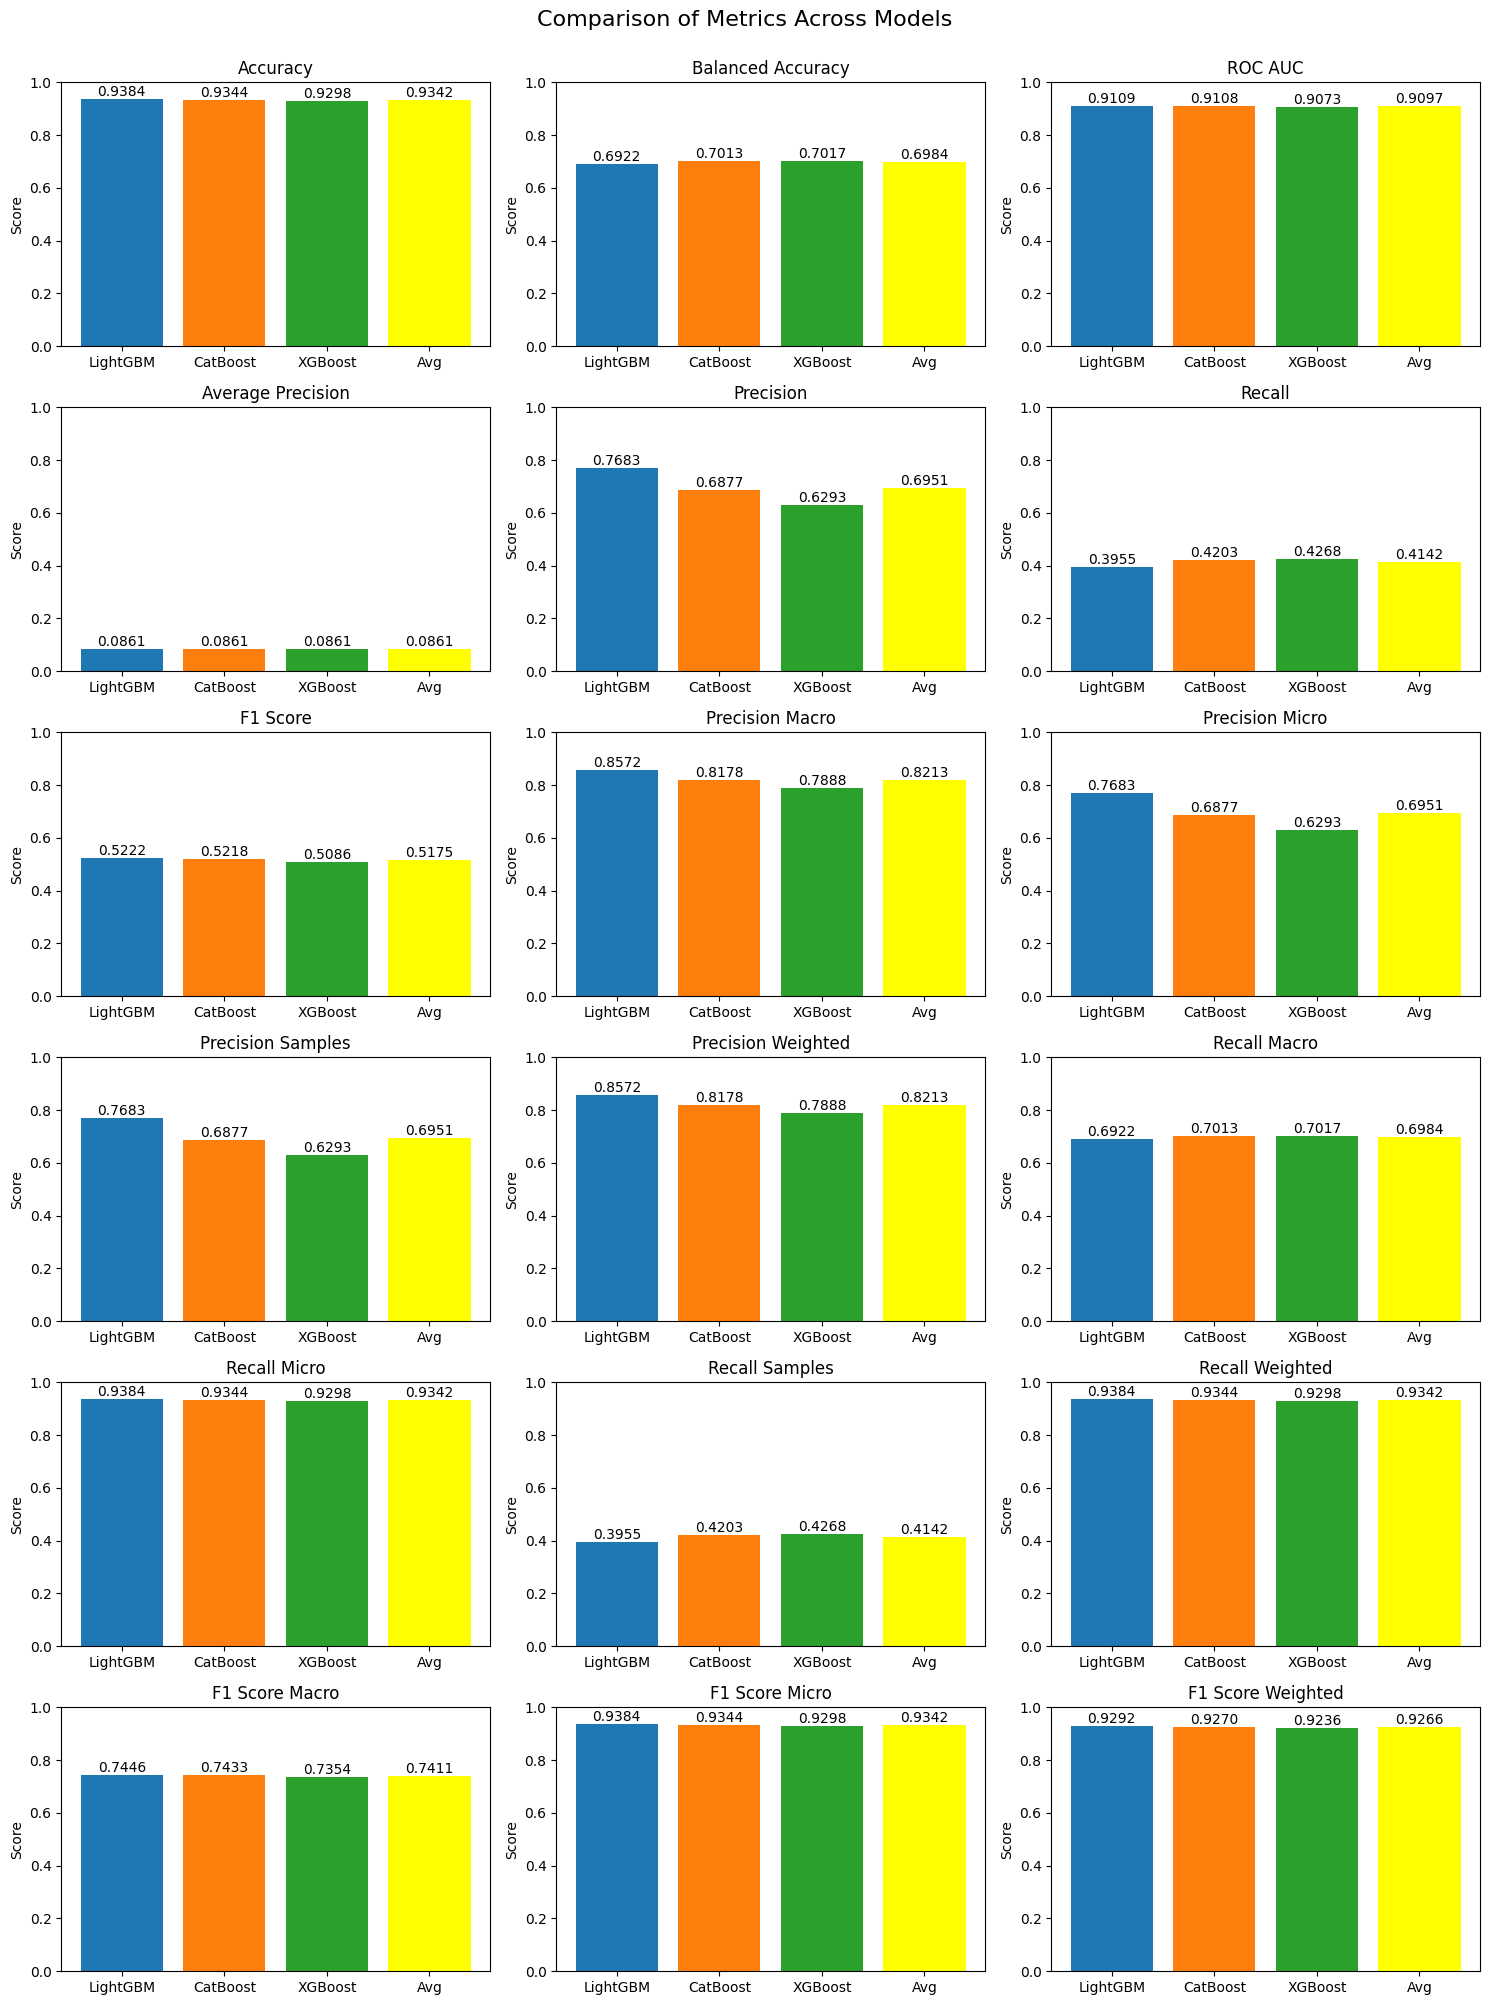

In [84]:
# Calculate the average of the rows
avg_values = (lightgbm_series + catboost_series + xgboost_series) / 3

# Convert the result to a list
avg_values = avg_values.tolist()
# Plotting
fig, axs = plt.subplots(6, 3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

for i, metric in enumerate(metrics):
    ax = axs[i // 3, i % 3]
    bars = ax.bar(['LightGBM', 'CatBoost', 'XGBoost','Avg'], [lightgbm_values[i], catboost_values[i], xgboost_values[i],avg_values[i]], color=['#1f77b4', '#ff7f0e', '#2ca02c','yellow'])
    ax.set_title(metric)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    
    # Adding the value on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

plt.suptitle('Comparison of Metrics Across Models', fontsize=16, y=1)
plt.tight_layout()
plt.show()

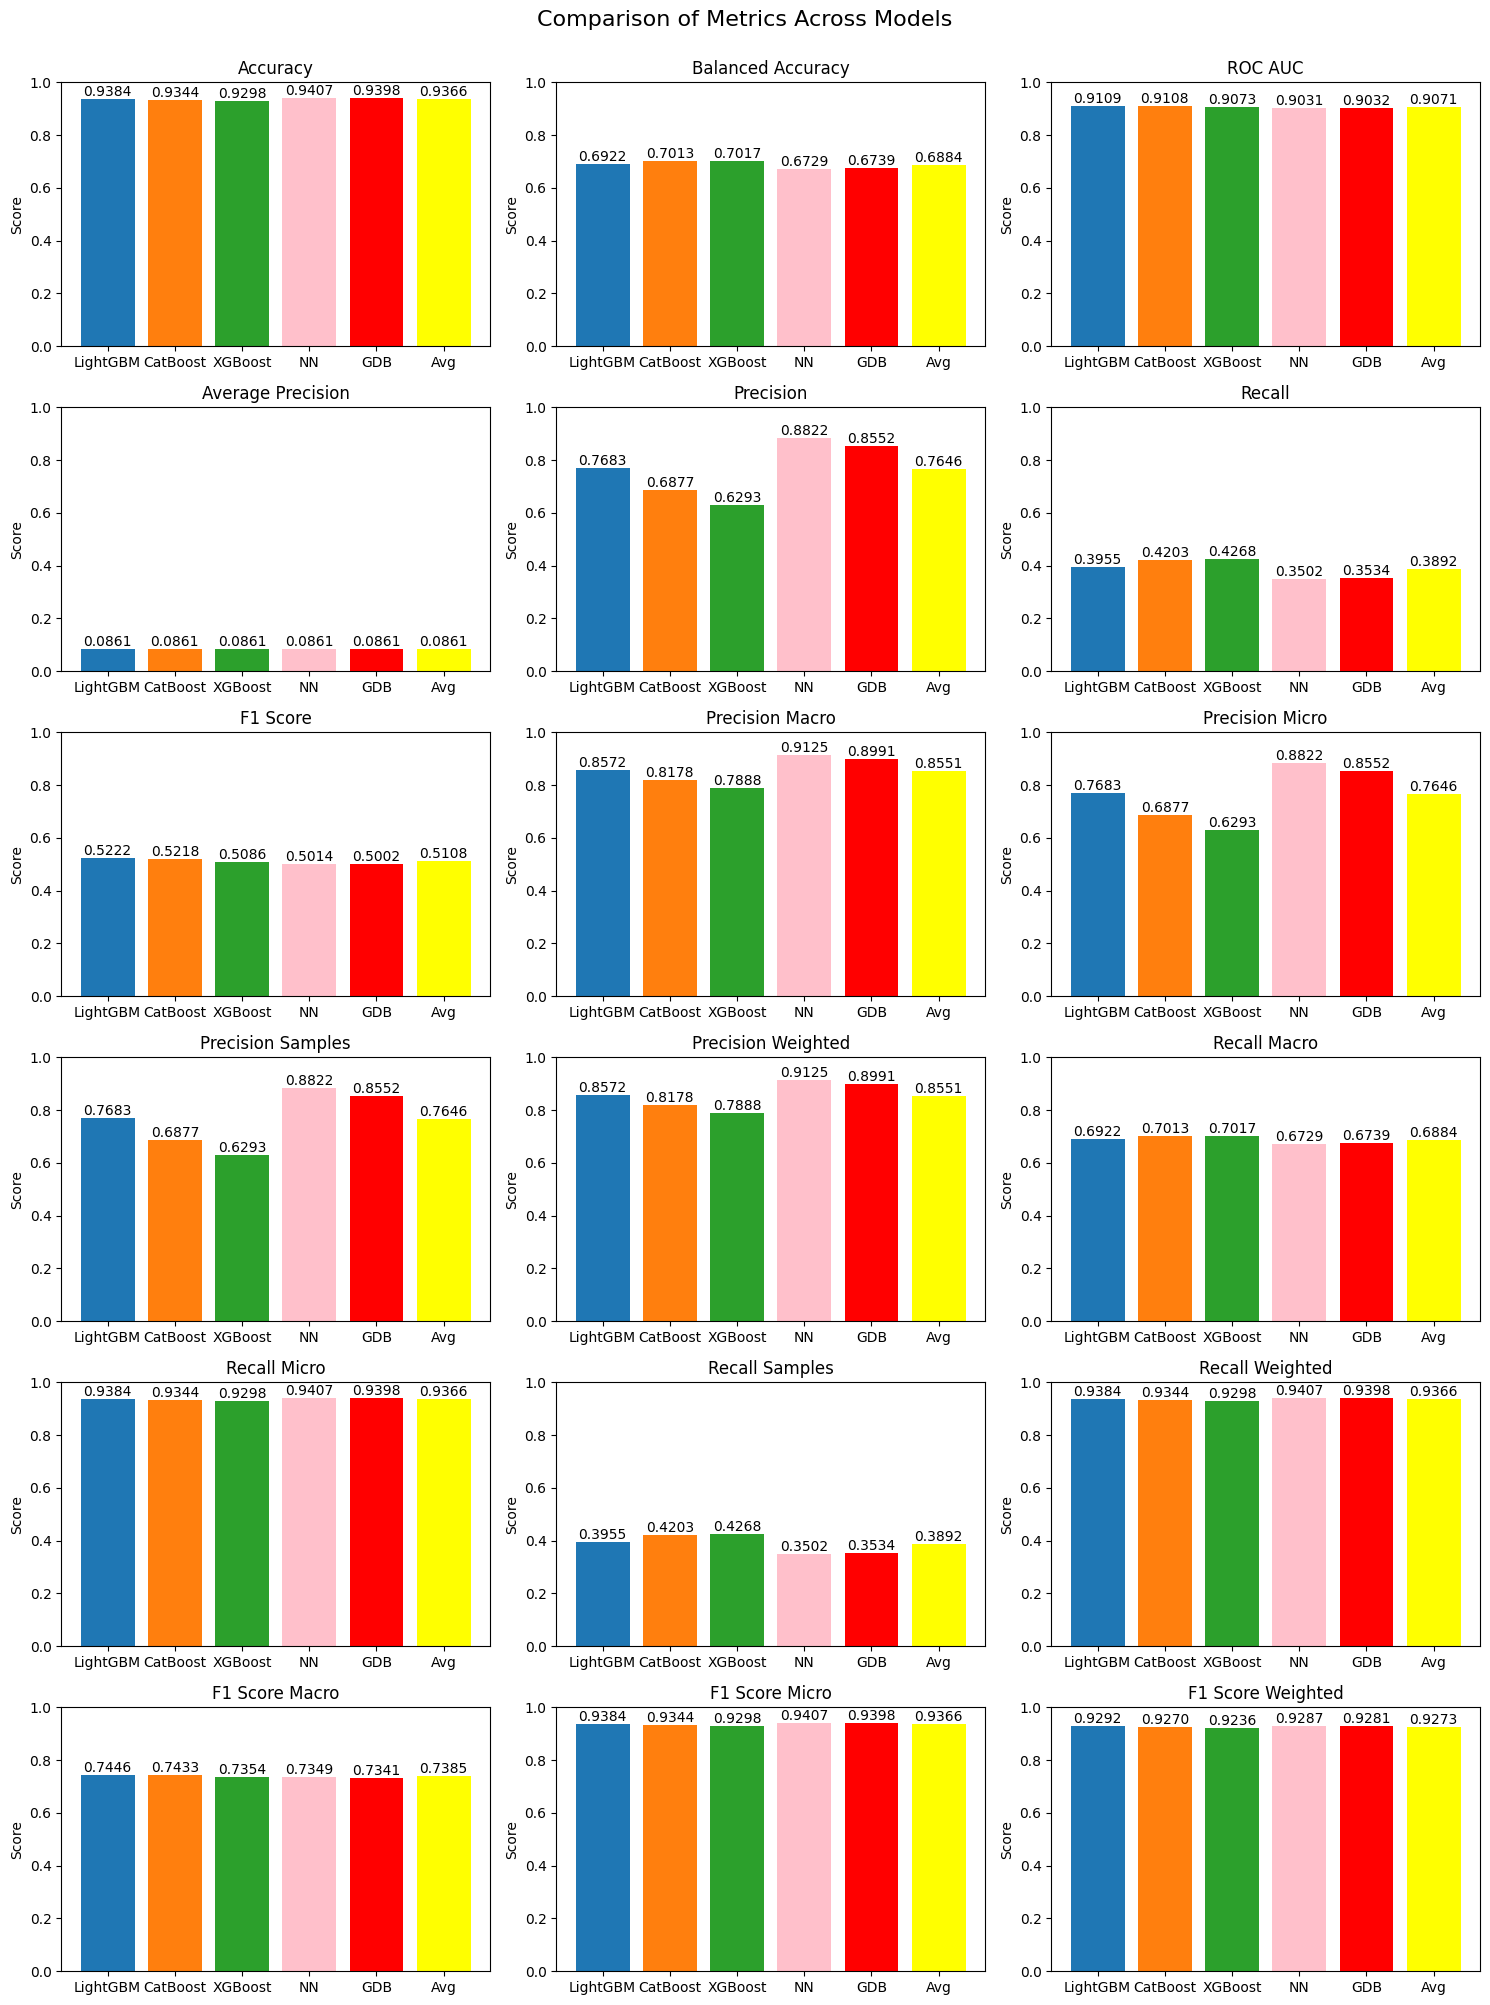

In [85]:
# Calculate the average of the rows
avg_values = (lightgbm_series + catboost_series + xgboost_series + nn_series + gdb_series) / 5

# Convert the result to a list
avg_values = avg_values.tolist()
# Plotting
fig, axs = plt.subplots(6, 3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

for i, metric in enumerate(metrics):
    ax = axs[i // 3, i % 3]
    bars = ax.bar(['LightGBM', 'CatBoost', 'XGBoost','NN','GDB','Avg'], [lightgbm_values[i], catboost_values[i], xgboost_values[i],nn_values[i],gdb_values[i],avg_values[i]], color=['#1f77b4', '#ff7f0e', '#2ca02c','pink','red','yellow'])
    ax.set_title(metric)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    
    # Adding the value on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

plt.suptitle('Comparison of Metrics Across Models', fontsize=16, y=1)
plt.tight_layout()
plt.show()

In [1]:
# !zip -r SMOTE_Model_Weights.zip /kaggle/working

In [134]:
output_directory = "/kaggle/working"
test2 = pd.DataFrame(test_scaled.index)
all_predicted_probs = test2.copy()  # Create a copy of test2 to avoid issues

test1 = pd.DataFrame(test_scaled.index)

for model_name in ['KNN', 'CB', 'RF', 'DT', 'LogReg', 'GNB', 'XGB', 'LGBM', 'GDB', 'AdB']:
    column_names = []
    for i in range(1, 11):
        model_file = model_name + '_B1_SMOTE_2604_fold_' + str(i)
        model = joblib.load(os.path.join(output_directory, model_file))
        predicted_probabilities = model.predict_proba(test_scaled)[:, 1]
        model_prob = pd.DataFrame({'employee_id': test_scaled.index, model_file: predicted_probabilities})
        all_predicted_probs = pd.merge(all_predicted_probs, model_prob, on='employee_id', how='left')
        column_names.append(model_file)

    all_predicted_probs[model_name] = all_predicted_probs[column_names].mean(axis=1)
    threshold = 0.4
    all_predicted_probs.iloc[:, 1:] = (all_predicted_probs.iloc[:, 1:] >= threshold).astype(int)

# Merge with test1 DataFrame
all_predicted_probs = pd.merge(test1, all_predicted_probs[['employee_id'] + ['KNN', 'CB', 'RF', 'DT', 'LogReg', 'GNB', 'XGB', 'LGBM', 'GDB', 'AdB']], on='employee_id', how='left')

In [135]:
all_predicted_probs.to_csv('Base_model_submission_SMOTE.csv', index = False)

In [136]:
all_predicted_probs.shape

(23490, 11)

In [138]:
all_predicted_probs.head()

,employee_id,KNN,CB,RF,DT,LogReg,GNB,XGB,LGBM,GDB,AdB
0,8724,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,74430,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,72255,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,38562,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,64486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [129]:
output_directory = "/kaggle/working"
test2 = pd.DataFrame(X_train_scaled.index, y_train)
all_predicted_probs = test2.copy()  # Create a copy of test2 to avoid issues

test1 = pd.DataFrame(X_train_scaled.index, y_train)

for model_name in ['KNN', 'CB', 'RF', 'DT', 'LogReg', 'GNB', 'XGB', 'LGBM', 'GDB', 'AdB']:
    column_names = []
    for i in range(1, 11):
        model_file = model_name + '_B1_SMOTE_2604_fold_' + str(i)
        model = joblib.load(os.path.join(output_directory, model_file))
        predicted_probabilities = model.predict_proba(X_train_scaled)[:, 1]
        model_prob = pd.DataFrame({'employee_id': X_train_scaled.index, model_file: predicted_probabilities})
        all_predicted_probs = pd.merge(all_predicted_probs, model_prob, on='employee_id', how='left')
        column_names.append(model_file)

    all_predicted_probs[model_name] = all_predicted_probs[column_names].mean(axis=1)
    threshold = 0.4
    all_predicted_probs.iloc[:, 1:] = (all_predicted_probs.iloc[:, 1:] >= threshold).astype(int)

# Merge with test1 DataFrame
all_predicted_probs = pd.merge(test1, all_predicted_probs[['employee_id'] + ['KNN', 'CB', 'RF', 'DT', 'LogReg', 'GNB', 'XGB', 'LGBM', 'GDB', 'AdB']], on='employee_id', how='left')

In [130]:
all_predicted_probs.head(2)

,employee_id,KNN,CB,RF,DT,LogReg,GNB,XGB,LGBM,GDB,AdB
0,13122,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,39968,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [118]:
all_predicted_probs.to_csv('Base_model_Train_Imbalanced.csv', index = False)

In [131]:
all_predicted_probs1 = pd.merge(all_predicted_probs, train[['employee_id','is_promoted'] ], on='employee_id', how='left')
all_predicted_probs1.head()

,employee_id,KNN,CB,RF,DT,LogReg,GNB,XGB,LGBM,GDB,AdB,is_promoted
0,13122,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0
1,39968,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,73949,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
3,69370,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1
4,30640,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In this section, an exploration of various base classifiers was undertaken to identify the top classifiers for subsequent analysis. The following combinations will now be examined further:

1. Perform Feature Engineering and Evaluate the performance of models on the test set. 
2. Modelling and Evaluation of optimal ANN architectures on the raw data as well as on generated features data. Determine if ANN should be included among the top-performing models.
3. Assessment of the top N models using Cost Sensitive Classifiers to investigate their performance under different class weighting schemes.
4. Finalization of the top models based on their performance on the test set.

Note:- We are not preferring SMOTE or any oversampling technique for further analysis.

The process of final model optimization will involve the following steps:

1. Tuning hyperparameters of the base classifiers to optimize their performance.
2. Implementing an ensembling framework to leverage the strengths of multiple models for improved predictive accuracy.

### Rough work 

In [132]:
from sklearn.metrics import f1_score
model = ['KNN', 'CB', 'RF', 'DT', 'LogReg', 'GNB', 'XGB', 'LGBM', 'GDB', 'AdB']
# Assuming 'true_labels_column' contains the true labels and 'predicted_labels_column' contains the predicted labels
true_labels = all_predicted_probs1['is_promoted']
for m in model:
    predicted_labels = all_predicted_probs1[m]
#     print(predicted_labels)

# Compute the F1 score
    f1 = f1_score(true_labels, predicted_labels)

    print(m," F1 Score:", f1)

KNN  F1 Score: 0.5311841430768354
CB  F1 Score: 0.612549240292628
RF  F1 Score: 0.9983941762123969
DT  F1 Score: 0.9985010706638116
LogReg  F1 Score: 0.36464138055006295
GNB  F1 Score: 0.1828228995259965
XGB  F1 Score: 0.6160833555971146
LGBM  F1 Score: 0.5491610040216336
GDB  F1 Score: 0.3693946188340807
AdB  F1 Score: 0.15696108792244512


In [303]:
# Step 1: List all the model files in the Kaggle output directory
# output_directory = "/kaggle/working"  # Update this path if needed
model_files = ['KNN_B1_SMOTE_2604_fold_4',
               'CB_B1_SMOTE_2604_fold_4',
               'RF_B1_SMOTE_2604_fold_4',
               'DT_B1_SMOTE_2604_fold_4',
               'LogReg_B1_SMOTE_2604_fold_4',
               'GNB_B1_SMOTE_2604_fold_4',
               'XGB_B1_SMOTE_2604_fold_4',
#                'ANN_3_Layer_Model1_Arch_B1_SMOTE_Treatment_fold_4.weights.h5',
               'LGBM_B1_SMOTE_2604_fold_4',
               'GDB_B1_SMOTE_2604_fold_4',
               'AdB_B1_SMOTE_2604_fold_4']

# Assuming you have test data (X_test_scaled)
# Step 2: Load each model file and make predictions
for model_file in model_files:
    # Load the model
    model = joblib.load(os.path.join(output_directory, model_file))
    
    # Make predictions
    predicted_probabilities = model.predict_proba(X_test_scaled)[:, 1]
    
    # Print the predicted probabilities
    print(f"Model: {model_file}")
    print(predicted_probabilities)
    print("-" * 50)  # Separating each model's output for clarity


Model: KNN_B1_SMOTE_2604_fold_4
[0.  0.  0.4 0.8 1.  0.  0.  0.2 0.  0.  0.  0.8 0.8 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.2 0.  0.  0.4 0.  0.6 0.8 0.  0.8 0.6 0.4 0.  0.
 0.4 0.2 0.8 0.  0.  0.  0.8 0.8 0.  0.  0.2 0.4 0.4 0.  0.  0.  0.  0.
 0. ]
--------------------------------------------------
Model: CB_B1_SMOTE_2604_fold_4
[9.83097944e-01 8.99406514e-04 1.42073403e-02 2.05674083e-01
 2.13387588e-01 1.71960242e-01 5.10890574e-03 9.37598661e-01
 8.23326527e-02 8.29793741e-04 4.53142368e-04 2.09745192e-01
 3.70720158e-02 2.02602012e-04 7.56718908e-04 1.41343994e-01
 4.56495739e-04 3.93541513e-04 1.85084769e-03 8.54155464e-05
 1.26212849e-04 4.48924953e-03 1.53638196e-04 9.52173132e-02
 3.41349652e-03 3.65006029e-05 1.82468061e-01 1.88537106e-04
 8.66340749e-03 1.95792523e-01 6.59549744e-04 3.33329450e-01
 7.10179835e-02 1.84731382e-01 1.73493483e-03 2.43916322e-01
 2.57006349e-01 8.81076527e-02 4.41922246e-02 5.55866712e-02
 8.94461547e-03 7.42173957e-05 2.15245871e-01 2.018186

In [168]:
model = Sequential()
model.add(Dense(50, input_dim=58, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu', kernel_initializer='normal'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')
# Load the weights
weights_path = '/kaggle/working/ANN_3_Layer_Model1_Arch_B1_SMOTE_Treatment_fold_4.weights.h5'
model.load_weights(weights_path)

predictions = model.predict(X_test_scaled)

# Print the predictions
print(predictions.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(55, 1)
